In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from os import path, listdir

from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class VehiclesDataset(Dataset):
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        self.images = listdir(path.join(dataset_dir, 'reconstructed'))[:2000]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        reconstructed = read_image(
            path.join(self.dataset_dir, 'reconstructed', self.images[idx]),
            ImageReadMode.RGB
        ) / 255.0
        original = read_image(
            path.join(self.dataset_dir, 'original', self.images[idx]),
            ImageReadMode.RGB
        ) / 255.0

        return reconstructed, original

In [3]:
from torch import nn
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

class Detailer(nn.Module):
    def __init__(self, encoder_params, decoder_params, output_params, loss='l1'):
        super().__init__()

        self.encoder = nn.ModuleList()
        for i, (out_channels, kernel_size) in enumerate(encoder_params):
            in_channels = 3 if i == 0 else encoder_params[i - 1][0]
            self.encoder.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding='same'),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
                nn.MaxPool2d(2)
            ))

        self.decoder = nn.ModuleList()
        for i, (out_channels, kernel_size) in enumerate(decoder_params):
            in_channels = encoder_params[-1][0] if i == 0 else decoder_params[i - 1][0]
            self.decoder.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding='same'),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
                nn.Upsample(scale_factor=2)
            ))
        
        self.output = nn.Sequential(
            nn.Conv2d(decoder_params[-1][0], *output_params, padding='same'),
            nn.Sigmoid()
        )

        if loss not in {'l1', 'l2', 'bce', 'ssim', 'lpips'}:
            raise ValueError('Loss needs to be one of ["l1", "l2", "bce", "ssim", "lpips"]')
        
        self._loss = loss
        
        if loss == 'l1':
            self.loss_function = nn.L1Loss()
        elif loss == 'l2':
            self.loss_function = nn.MSELoss()
        elif loss == 'bce':
            self.loss_function = nn.BCELoss()
        elif loss == 'ssim':
            self.loss_function = StructuralSimilarityIndexMeasure().to(device)
        elif loss == 'lpips':
            self.loss_function = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)

        for layer in self.decoder:
            x = layer(x)
        
        return self.output(x)
    
    def loss(self, outputs, targets):
        alpha = 0.2
        l = self.loss_function(outputs, targets)

        if self._loss == 'ssim':
            l = 1 - l
        
        # l = alpha * l + (1 - alpha) * nn.L1Loss()(outputs, targets)
        
        if self._loss == 'lpips':
            self.loss_function = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)
        
        return l

In [9]:
from torchinfo import summary

model = Detailer(
    encoder_params=[(32, 3), (64, 5), (128, 5)],
    decoder_params=[(128, 3), (64, 5), (32, 5)],
    output_params=(3, 5),
    loss='l1'
).to(device)

summary(model, (32, 3, 256, 256), device=torch.device(device))

Layer (type:depth-idx)                   Output Shape              Param #
Detailer                                 [32, 3, 256, 256]         --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [32, 32, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 32, 256, 256]        896
│    │    └─ReLU: 3-2                    [32, 32, 256, 256]        --
│    │    └─BatchNorm2d: 3-3             [32, 32, 256, 256]        64
│    │    └─MaxPool2d: 3-4               [32, 32, 128, 128]        --
│    └─Sequential: 2-2                   [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-5                  [32, 64, 128, 128]        51,264
│    │    └─ReLU: 3-6                    [32, 64, 128, 128]        --
│    │    └─BatchNorm2d: 3-7             [32, 64, 128, 128]        128
│    │    └─MaxPool2d: 3-8               [32, 64, 64, 64]          --
│    └─Sequential: 2-3                   [32, 128, 32, 32]         --
│    │   

In [11]:
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

epochs = 10
batch_size = 32

dataset = VehiclesDataset(path.join('..', '..', 'dataset'))
dataset_train, dataset_val, dataset_test = random_split(
    dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(1)
)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    pbar = tqdm(total=(len(dataloader_train) + len(dataloader_val)))

    train_loss = 0.0
    model.train()
    for i, (reconstructed, original) in enumerate(dataloader_train):
        reconstructed, original = reconstructed.to(device), original.to(device)

        optimizer.zero_grad()
        outputs = model(reconstructed)
        loss = model.loss(outputs, original)
        loss.backward()
        optimizer.step()

        train_loss += loss

        pbar.set_description(
            f'Epoch {epoch + 1:3}, '
            f'train loss: {train_loss / (i + 1):5f}'
        )
        pbar.update(1)

        reconstructed.detach()
        original.detach()
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, (reconstructed, original) in enumerate(dataloader_val):
            reconstructed, original = reconstructed.to(device), original.to(device)

            outputs = model(reconstructed)
            loss = model.loss(outputs, original)

            val_loss += loss

            pbar.set_description(
                f'Epoch {epoch + 1:3} - '
                f'loss {train_loss / (i + 1):5f} - '
                f'val_loss {val_loss / (j + 1):5f}'
            )
            pbar.update(1)

            reconstructed.detach()
            original.detach()

Epoch   9 - loss 0.072239 - val_loss 0.069787: 100%|██████████| 57/57 [00:32<00:00,  1.74it/s]


loss    |   rec   |   out   |
l1      |  0.0576 |  0.0588 |
l2      |  0.0097 |  0.0101 |
bce     |  0.4863 |  0.4875 |
ssim    |  0.5795 |  0.5590 |
lpips   |  0.4887 |  0.6272 |


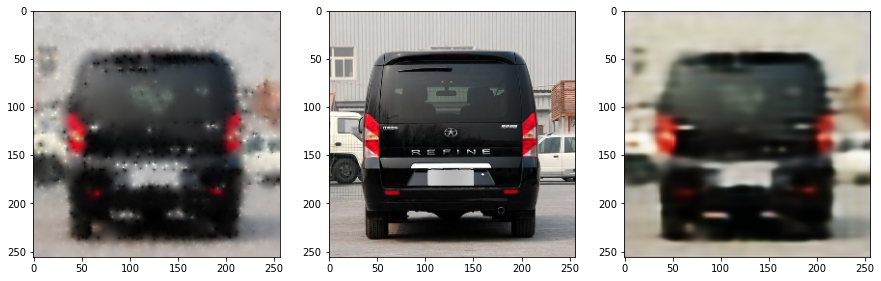

In [15]:
reconstructed, original = dataset_test[0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(reconstructed.permute((1, 2, 0)))
plt.subplot(1, 3, 2)
plt.imshow(original.permute((1, 2, 0)))

reconstructed = reconstructed[None, :].to(device)
original = original[None, :].to(device)
output = model(reconstructed)

print(f'{"loss":7} | {"rec":^7} | {"out":^7} |')
for loss in ['l1', 'l2', 'bce', 'ssim', 'lpips']:
    print(f'{loss:7}', end=' |')
    for image in [reconstructed, output]:
        if loss == 'l1':
            loss_function = nn.L1Loss()
        elif loss == 'l2':
            loss_function = nn.MSELoss()
        elif loss == 'bce':
            loss_function = nn.BCELoss()
        elif loss == 'ssim':
            loss_function = StructuralSimilarityIndexMeasure().to(device)
        elif loss == 'lpips':
            loss_function = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)
        
        print(f'{loss_function(image, original):8.4f}', end=' |')
    print()
    
plt.subplot(1, 3, 3)
plt.imshow(output.cpu().detach()[0].permute((1, 2, 0)))

plt.show()